In [1]:
from multiprocessing import Pool
from scipy.stats import poisson
from scipy.optimize import curve_fit
from scipy.signal import convolve2d
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
plt.style.use(astropy_mpl_style)
import emcee
import corner
from IPython.display import display, Math
from fonctions import *


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_24843/496026857.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


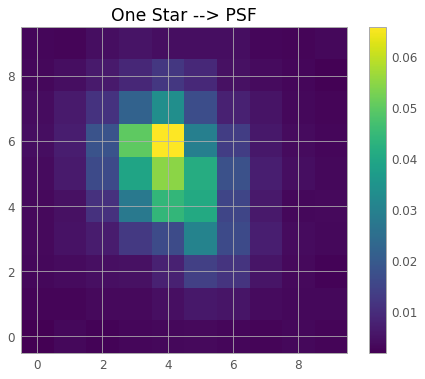

In [2]:
# Opening the images
img = fits.getdata('image2.fit')
bias = fits.getdata('bias.fit')
dark = fits.getdata('dark.fit')
flat = fits.getdata('flat.fit')

# Averaging the calibration frames
bias = averageFolder('bias')
dark = averageFolder('dark')
flat = averageFolder('flat')

# Image calibrated using the different calibration frames
image_clean = calibrate(img, bias, dark, flat)

# PSF of one star
#PSF = image_clean[2926-10:2926+10, 2029-10:2029+10]
PSF = image_clean[2628:2638, 822:832]
PSF = PSF / np.sum(PSF)  # normalized as a distribution to 1
plt.figure()
plt.title('One Star --> PSF')
plt.imshow(PSF, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_24843/253592785.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


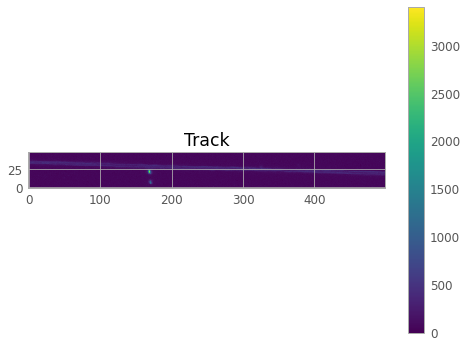

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_24843/253592785.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


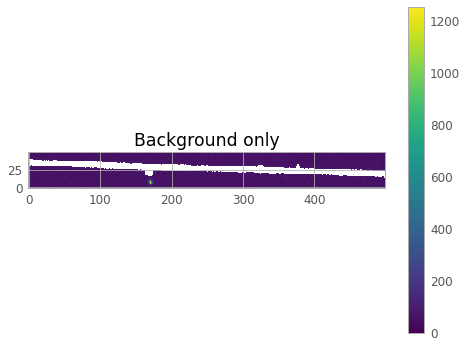

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_24843/253592785.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


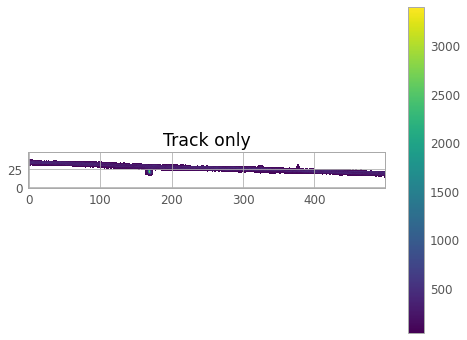

In [3]:
# small outcut of a track
track_data = image_clean[2780:2830,0:500]
avg = np.mean(track_data)
mask = make_source_mask(track_data, nsigma=4, npixels=1000, dilate_size=2)
track = np.ma.array(track_data, mask=np.logical_not(mask), fill_value=0)
mean, median, std = sigma_clipped_stats(track_data, sigma=4.0, mask=mask)
mask = make_source_mask(track_data, nsigma=4, npixels=1000, dilate_size=2)
masked_image = np.ma.masked_where(mask, track_data)

plt.figure()
plt.title('Track')
plt.imshow(track_data, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background only')
plt.imshow(masked_image, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Track only')
plt.imshow(track, origin='lower', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_24843/3798406460.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(ticks=ticks)


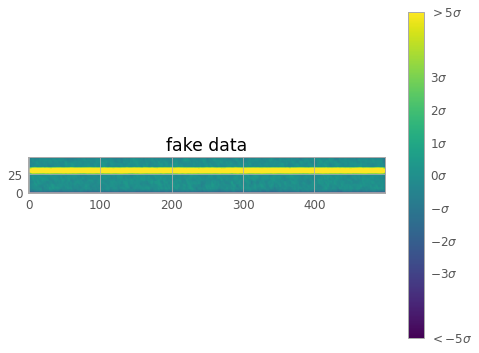

In [4]:
# Create fake data
true_parameters = (30, 30, 1, 1000)
track_data = simplerTrackModel(np.shape(track_data), *true_parameters) + np.random.normal(loc=mean, scale=std, size=np.shape(track_data))
track_data = convolve2d(track_data, PSF, 'same')

tick_labels = [r'$<-5\sigma$', r'$-3\sigma$', r'$-2\sigma$', r'$-\sigma$', r'$0\sigma$', r'$1\sigma$', r'$2\sigma$', r'$3\sigma$', r'$>5\sigma$']
ticks = mean + std * np.array([-5, -3, -2, -1, 0, 1, 2, 3, 5])

plt.figure()
plt.title('fake data')
plt.imshow(track_data, origin='lower', cmap='viridis', interpolation='none', vmin=-5*std+mean, vmax=5*std+mean)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.set_yticklabels(tick_labels)
plt.show()

/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_24843/921775282.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(ticks=ticks)


98.24746157467868


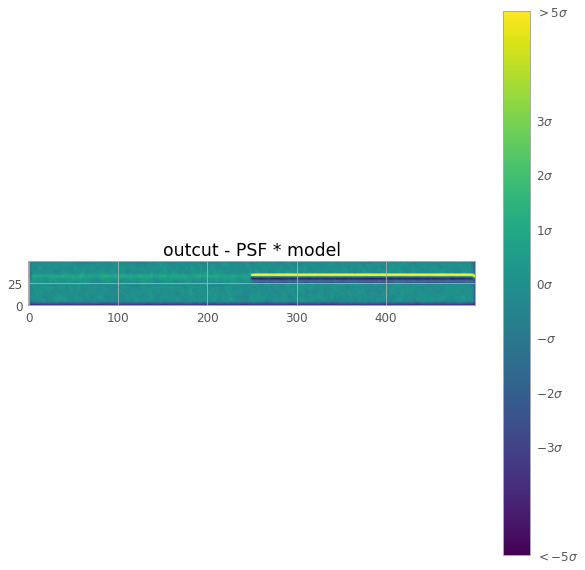

In [5]:
# Convolution of model and PSF to get what we would measure
initial_guess = (31, 29, 1, 950)
track_model = simplerTrackModel(np.shape(track_data), *initial_guess)
convolved_track = convolve2d(track_model, PSF, 'same')
#mean, median, std = sigma_clipped_stats(track_data, sigma=4.0, mask=mask)
print(reducedGoodnessModel(track_data, convolved_track, std))

plt.figure(figsize=(10,10))
plt.title('outcut - PSF * model')
plt.imshow(track_data-convolved_track, origin='lower', cmap='viridis', interpolation='none', vmin=-5*std+mean, vmax=5*std+mean)
cbar = plt.colorbar(ticks=ticks)
cbar.ax.set_yticklabels(tick_labels)
plt.show()

In [6]:
# Model parameter fitting using Marginalization & uncertainty estimation
# source https://emcee.readthedocs.io/en/stable/tutorials/line/
pos = initial_guess + np.random.randn(200, 4)
nwalkers, ndim = pos.shape
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args=(track_data, std, PSF), pool=pool)
    sampler.run_mcmc(pos, 1000, progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [03:51<00:00,  4.33it/s]


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 65.78714417  73.52211367  82.29797876 103.04698572]

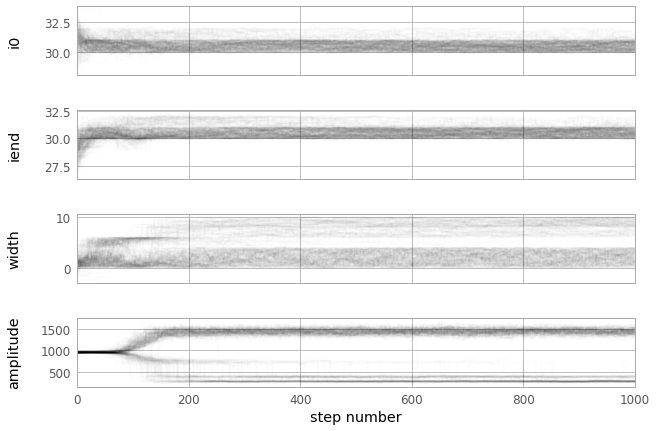

In [7]:
# looking at the steps
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["i0", "iend", "width", "amplitude"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.01)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# autocorrection time
tau = sampler.get_autocorr_time()
print(tau)


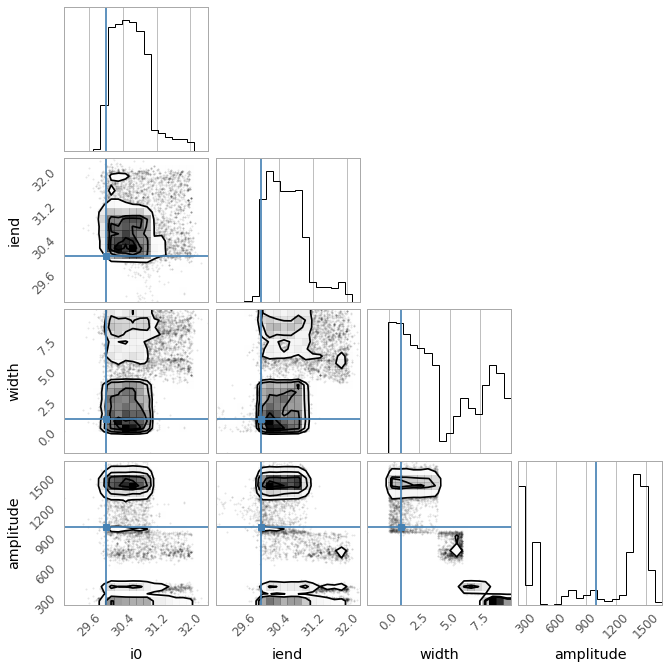

In [8]:
flat_samples = sampler.get_chain(discard=50, thin=10, flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=[30, 30, 1, 1000])

In [41]:
# percentiles
theta = [0, 0, 0, 0]
theta_error = [0, 0, 0, 0]
for i in range(ndim):
    theta[i] = np.mean(flat_samples[:, i])
    theta_error[i] = np.std(flat_samples[:,i])
    txt = "\mathrm{{{2}}} = {0:.1f} +- {{{1:.1f}}}"
    txt = txt.format(theta[i], theta_error[i], labels[i])
    display(Math(txt))



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

chi^2:  2.376086599035421


/var/folders/f6/yq2zbwvx48ngrtbv1qf7dgf40000gn/T/ipykernel_24843/398131299.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ca = plt.colorbar(ticks=ticks)


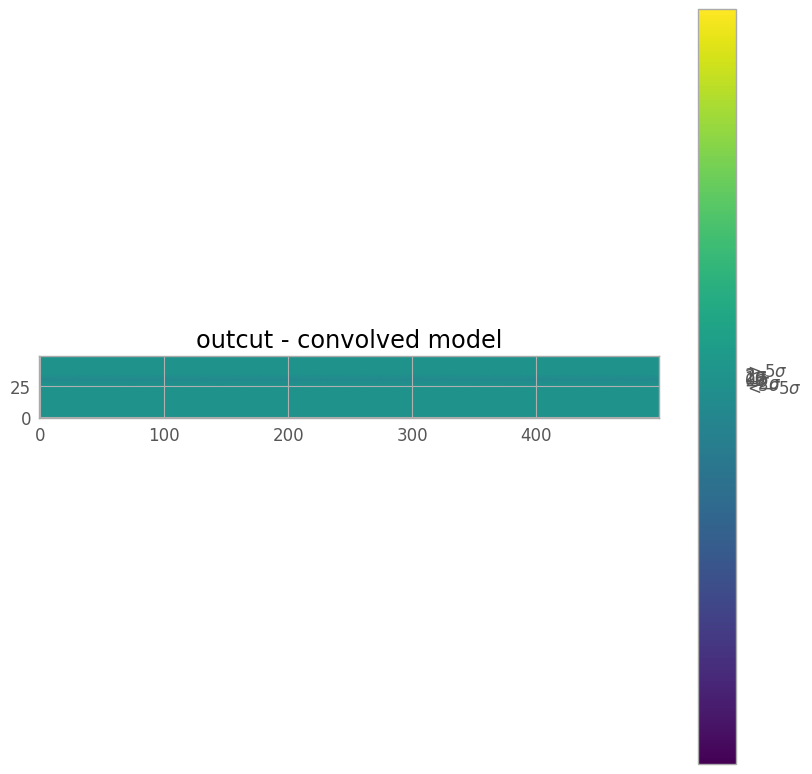

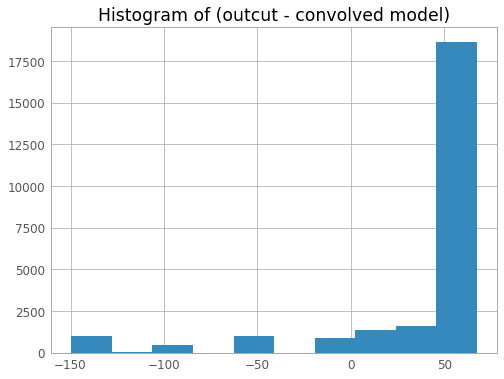

In [42]:
# best model
best_model = convolve2d(simplerTrackModel(
    np.shape(track_data), *theta), PSF, 'same')
chi2 = reducedGoodnessModel(track_data, best_model, std)
print('chi^2: ', chi2)

plt.figure(figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
plt.title('outcut - convolved model')
#norm = ImageNormalize(stretch=SqrtStretch())
img = track_data - best_model
plt.imshow(img, origin='lower', cmap='viridis', interpolation='none', vmin=-5*std, vmax=5*std)
ca = plt.colorbar(ticks=ticks)
ca.ax.set_yticklabels(tick_labels)
plt.show()

#matplotlib.rcParams['figure.f#igsize'] = [10, 10]
plt.figure()
plt.title('Histogram of (outcut - convolved model)')
plt.hist(img.flatten(), bins=10)
#plt.yscale('log')
plt.show()


OptimizeWarning: Covariance of the parameters could not be estimated

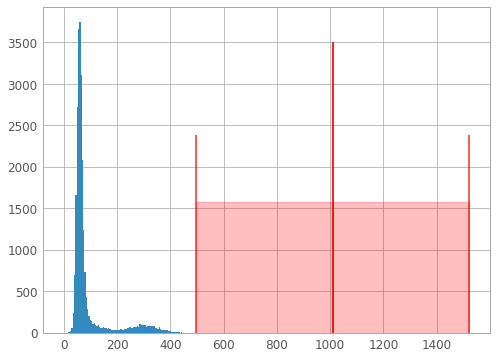

In [45]:
# signal to noise ratio of the track

# poisson distribution, for fitting
def fitfun(k, lamb):
    return poisson.pmf(k, lamb)

# histogram of background noise compared to amplitude of track
plt.figure()
entries, bin_edges, patches = plt.hist(masked_image.flatten(), bins=256, label='background noise')
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
std_amplitude = np.std(flat_samples[:, -1])
amplitude = theta[-1]
plt.vlines(amplitude, ymin=0, ymax=3500, label='Track amplitude', color='r')
plt.vlines([amplitude-std_amplitude, amplitude+std_amplitude],
           ymin=0, ymax=[0.68*3500, 0.68*3500], label='Track amplitude std dev', color='r', alpha=0.75)
plt.axvspan(amplitude-std_amplitude, amplitude, alpha=0.25, color='red', ymin=0, ymax=0.4)
plt.axvspan(amplitude, amplitude+std_amplitude,
            alpha=0.25, color='red', ymin=0, ymax=0.4)
#plt.plot(bin_middles, np.sum(entries) * poisson.pmf(bin_middles, 1e6), color='tab:orange', label='Poisson fit')
# Poisson fitting
initial_params = [np.mean(masked_image)]
parameters, cov_matrix = curve_fit(
    fitfun, bin_middles, entries, initial_params)

yfit = fitfun(bin_middles.astype(int), *parameters)
lbl = 'Poisson fit mu={:.2f}'.format(parameters[0])
plt.plot(bin_middles.astype(int), np.sum(entries)/np.sum(yfit) * yfit, '--',
         color='tab:orange', label=lbl)
plt.xlabel(r'Brightness')
plt.ylabel('count')
plt.legend()
plt.show()

SNR = (amplitude-parameters[0])/parameters[0]
print('SNR = {:.2f}'.format(SNR))

